In [1]:
import numpy as np
import matplotlib.pylab as plt
import E5071C 
import DataModule as dm
from scipy.optimize import fsolve
import time
import signal
import sys
from IPython import display
from SensorReader import*
from progress_bar import InitBar
from SIGGEN import*
from IPLIST import*
from UtilitiesLib import*
#import circuit as cf

%matplotlib inline

E5071C v1.0.2
DataModule v1.2.4
circuit v1.1.4
fit_toolbox v1.0.3
Sensor reader v1.0.0
SIGGEN v1.2.0
UtilitiesLib v1.1.5


In [2]:
vna = E5071C.VNA(IPList['VNA1'])
vna.identify()

'2K5'

In [3]:
sg = Siggen(IPList['MXG']) 
sg.output(0)
#mxg.close()

Agilent Technologies, N5183B, MY53270396, B.01.51


In [4]:
SR=SensorReader()
def twotone_ave(vna,vna_fstart,vna_fstop,vna_power,ave_num,BW,sig,sig_power,sig_freqs, npoints,plot=True, plot_levs = 10):
    
    # handling keyboard interruption
    def signal_handler(signal, frame):
        print('Process interrupted! Closing sockets...')
        sig.output(0) # RF out set to off
        sig.close() # close signal generator connection
        sys.exit(0)
    
    signal.signal(signal.SIGINT, signal_handler)
    
    
    # quick guessing of data amplitude range
    d_tmp = vna.collect_single([vna_fstart,vna_fstop],'test',wait=10,power=vna_power)
    yavg = np.average(d_tmp.y)

    # setting up the signal generator
    sig.frequency_mode('FIX') # setting the frequency mode to CW (FIX)
    sig.power(sig_power) # setting the power 
    sig.output(1) # RF out set to on

    #initializing the data
    dat = dm.data_3d()
    dat.load_var(d_tmp.x,sig_freqs,yavg*np.ones((len(sig_freqs),len(d_tmp.x)))) 

    
    plt.figure(figsize=(16,12))

    #initializing the progress bar
    pb=InitBar('Measuring',len(sig_freqs))
    pb(0)
    
    #initializing the sensor reading for the temperature
    SR = SensorReader()
    
    
    cycle_start=time.time()
    
    for i in range(len(sig_freqs)):
        step_start=time.time()
        
        
        
        sig.frequency(sig_freqs[i])
        time.sleep(0.05)
        
        #dat.temp_start.append(SR.base_temp() )
        #dat.temp_start_time.append(SR.last_update())
        
        tmp = vna.collect_single_ave([vna_fstart,vna_fstop],npoints,navg=ave_num,power=vna_power,BW=BW,Temp_reading=False)
        
        dat.z[i,:]=tmp.y
        
        dat.time_start = tmp.time_start
        dat.time_stop = tmp.time_stop
        
        dat.temp_stop = SR.base_temp()
        dat.temp_stop_time = SR.last_update()   
        
        if plot is True:
            plt.pcolormesh(dat.x,dat.y,dat.z)
            display.clear_output(wait=True)
            display.display(plt.gcf())
    
        pb(i+1,'Extimated: '+time_difference(step_start,len(sig_freqs)-i-1)+'                ')
    
    pb(len(sig_freqs),'Time: '+time_difference(cycle_start)+'                ')
    
        
    display.clear_output(wait=True)
    
    dat.insert_par(sig_power = sig_power)
    dat.select()

    sig.output(0) # RF out set to off
    #sig.close() # close signal generator connection
    #vna.close() # close VNA connection
    return dat



In [18]:

dat_tt = twotone_ave(vna = vna,
                     vna_fstart =7.0757961-7e-3 ,
                     vna_fstop = 7.0757961+3e-3,
                     vna_power = -40,
                     ave_num= 3,
                     BW= 1000,
                     npoints=1601,
                          
                     sig = sg,
                     sig_power = 10,
                     sig_freqs = np.linspace(0.96,0.965,100),
                     plot=False)
#dat_tt.save('k75_fro=7.05_fext-4.79-60d.dm')

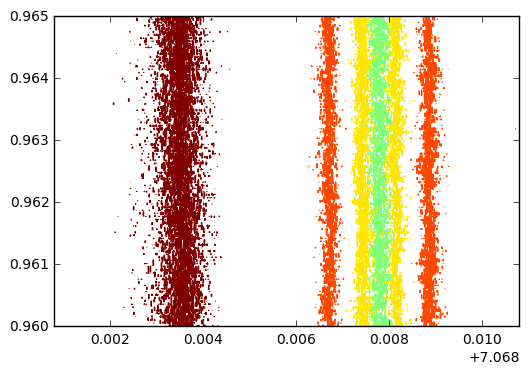

In [20]:
dat_tt.select(yrng=[0.96,0.965])
plt.contour(dat_tt.xsel,dat_tt.ysel,dat_tt.zsel)

In [19]:
dat_tt.save('k75_fro=7.05_pro-60dbm_fext-0.96-+10dBm.dm')

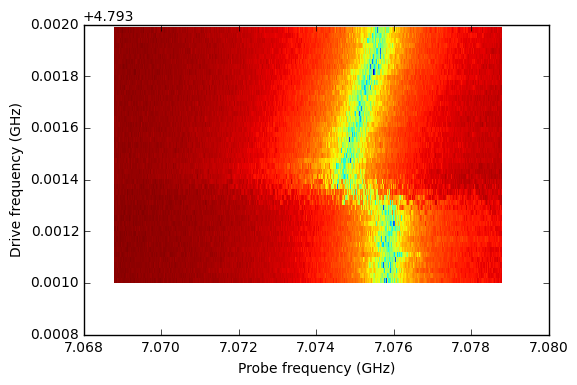

In [24]:
da=dm.load_datamodule('2016-10-18-k75_fro=7.05_pro-60dbm_fext-4.79-52dBm_1photons.dm')
da.pcolormesh()
plt.xlabel('Probe frequency (GHz)')
plt.ylabel('Drive frequency (GHz)')